In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Windy Gridworld

**Problem**: re-solve the windy gridworld assuming eight possible actions, including the diagonal moves, rather than four. How much better can you do with the extra actions? Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind?

First step would be to implement the base case and see if the result is similar to what is shown in the textbook

### Example 6.5 Windy Gridworld

Reach the goal from starting point. **Undiscounted** task with constant -1 rewards per time step until goal is reached.

Action space: [`up`, `down`, `left`,`right`]

State space: gridworld

In the middle region there is an upwind wind that causes next states to be shifted upwards. The strength varies from column to column.

Implement e-greedy SARSA. Consider $\epsilon = 0.1$ and $\alpha = 0.5$ and initial action-state values at 0. 

In [64]:
import numpy as np
import math

def create_grid(n_rows:int, n_columns:int) -> np.ndarray:
    return np.zeros((n_rows, n_columns), dtype = np.uint8)

class WindyGridWorld:
    """
    Action is in the form [left, up, right, down]
    """

    def __init__(self, rows, columns, wind_col_range):
        self.rows = rows
        self.columns = columns
        self.last_state = None
        self.wind_col_range = wind_col_range
        self.wind_magnitudes = self._setup_wind_magnitudes(wind_col_range)
        self.reset()

    def _set_initial_state(self) -> tuple[int, int]:
        return self.rows // 2, 0
    
    def _check_if_wind_affected(self, column: int)-> bool:
        pos_rel_to_wind = column - self.wind_col_range[0]
        if pos_rel_to_wind < 0 :
            return False
        if pos_rel_to_wind < self.wind_col_range[1] - self.wind_col_range[0]:
            return True
        return False

    
    def _compute_new_state(self, state: tuple[int, int], action: tuple[bool, bool, bool, bool]) -> tuple[int, int]:
        assert np.sum(action) == 1, "Multiple direction displacements not permited"
        left, up, right, down = action
        new_row = state[0] - up + down
        new_col = state[1] - left + right
        # upwind affects rows
        if (self._check_if_wind_affected(new_col)):
            new_row = new_row - self.wind_magnitudes["wind_values"][new_col - self.wind_col_range[0]]
        return new_row, new_col


    def _check_next_condition(self, new_row, new_col) -> bool:
        if new_row >= self.rows or new_row < 0:
            return False
        if new_col >= self.columns or new_col < 0:
            return False
        return True
    
    def _setup_wind_magnitudes(self, windy_col_range: tuple[int, int]) -> dict[str, tuple[int]]:
        min_col, max_col = windy_col_range
        affected_cols = [c for c in range(min_col, max_col)]
        wind_magnitudes = [min(i+1, 3) for i in range(math.ceil((max_col-min_col) / 2))]
        wind_magnitudes += wind_magnitudes[-1-(max_col-min_col)%2::-1]
        return {"columns":affected_cols,"wind_values":wind_magnitudes}

    def _update_grid_trayectory(self):
        self.grid[*self.last_state] = 1

    def plot_trayectory(self):
        plt.imshow(self.grid)
        plt.show()

    def reset(self):
        self.grid = create_grid(self.rows, self.columns)
        self.last_state = self._set_initial_state()
        self._update_grid_trayectory()
        return self.last_state

    def step(self, action: tuple[bool, bool, bool, bool]) -> tuple[tuple[int, int], int, bool]:
        """
        return state, reward, done
        """
        new_row, new_col = self._compute_new_state(self.last_state, action)
        if not self._check_next_condition(new_row, new_col):
            return self.last_state, 0, True
        self.last_state = (new_row, new_col)
        self._update_grid_trayectory()
        return (new_row, new_col), -1, False

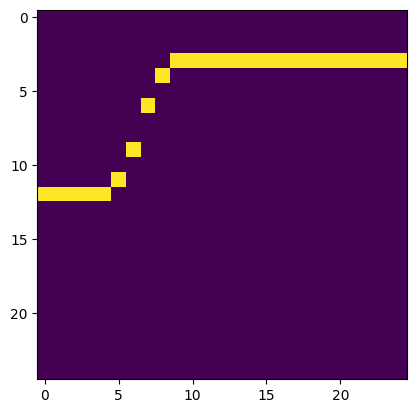

In [65]:
import matplotlib.pyplot as plt

gridworld = WindyGridWorld(25,25,(5,10))
for i in range(25):
    gridworld.step((0,0,1,0))
gridworld.plot_trayectory()